# Example 1: The image and probe reconstruction from simulated frames

In [1]:
import sys
import time
from datetime import timedelta, datetime, tzinfo
import argparse
import numpy as np
import h5py
import sharp
import sharpnsls2
import matplotlib.pyplot as plt
# make graphics inline
# %matplotlib inline
%matplotlib notebook

# Set the input parameters

In [2]:
niters = 51
inDir = '../../data/d1/'

z_m = 0.7495170470638932 # detector-to-sample distance (m)
ccd_pixel_um = 55 # detector pixel size (um)
lambda_nm = 0.15497979726416796 # x-ray wavelength (nm)

sharpNSLS2 = sharpnsls2.PySharpNSLS2()
sharpNSLS2.setZ(z_m)
sharpNSLS2.setLambda(lambda_nm)
sharpNSLS2.setPixelSize(ccd_pixel_um)

# Load and define an initial probe

In [3]:
init_prbFile = inDir + 'prb_init.npy'
init_prb = np.load(init_prbFile)

sharpNSLS2.setInitProbe(init_prb.astype(np.complex64))

print(init_prb.shape)

(384, 384)


# Load and define a scan

In [4]:
det_side = init_prb.shape[0]
real_pixel_size =  z_m*lambda_nm*1e-3/(det_side*ccd_pixel_um) # real space pixel size in m
corner_pos = [det_side/2*ccd_pixel_um*1e-6, det_side/2*ccd_pixel_um*1e-6, z_m]

scanFile   = inDir + 'scan.npy'
points  = np.load(scanFile)

X = points[0] # [-363, 362]
Y = points[1] # [-363, 363]

X -= min(X) 
Y -= min(Y)

# transpose X and Y for the input file
# pixel_translation = np.column_stack((X, Y, np.zeros(Y.size)))
pixel_translation = np.column_stack((Y, X, np.zeros(Y.size)))
real_translation = pixel_translation * real_pixel_size

# plt.scatter(X, Y)
# plt.show()

sharpNSLS2.setScan(real_translation.astype(np.float64))
print(real_pixel_size, min(X), max(X), min(Y), max(Y))

5.5000000000000004e-09 0.0 725.0 0.0 726.0


# Load and define an initial object

In [5]:
init_objFile = inDir + 'obj_init.npy'
init_obj = np.load(init_objFile)

obj_max_x = int(max(X) - min(X)) + det_side
obj_max_y = int(max(Y) - min(Y)) + det_side

init_obj = init_obj[0: obj_max_x, 0: obj_max_y]
sharpNSLS2.setInitObject(init_obj.astype(np.complex64))

print(obj_max_x, obj_max_y)

1109 1110


# Generate and define frames

In [6]:
# Load a probe

prbFile = inDir + 'probe.npy'
probe = np.load(prbFile)

# plt.subplot(1,2,1)
# plt.imshow(abs(probe))
# plt.subplot(1,2,2)
# plt.imshow(np.angle(probe))

# Load an object

objectFile = inDir + 'object.npy'
object = np.load(objectFile) # (1170, 1172)

object = object[0: obj_max_x, 0: obj_max_y]

# plt.subplot(1,2,1)
# plt.imshow(abs(object))
# plt.subplot(1,2,2)
# plt.imshow(np.angle(object))

# Generate and define frames using scan, probe, and object

nframes = X.size

objFrames = np.empty((nframes,det_side,det_side), dtype = complex)
frames = np.empty((nframes,det_side,det_side))

for i in range(0,nframes):
    ix = int(X[i])
    iy = int(Y[i])
    objFrames[i] = object[ ix : ix + det_side, iy : iy + det_side]   
    frames[i] = np.abs(np.fft.fftshift(np.fft.fft2(probe*objFrames[i])))**2
    frames[i] = frames[i]/(det_side*det_side)
    
sharpNSLS2.setFrames(frames.astype(np.float32))

# Set the SHARP-NSLS2 parameters

In [7]:
sharpNSLS2.setStartUpdateObject(0)
sharpNSLS2.setStartUpdateProbe(2)
sharpNSLS2.setChunks(4)

# Initialize the SHARP-NSLS2 containers

In [8]:
sharpNSLS2.init()

0

# Plot the initial object and probe

<IPython.core.display.Javascript object>


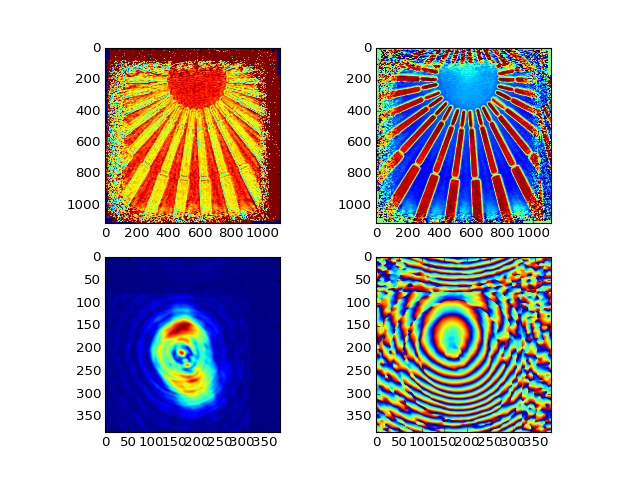

In [9]:
# f, (ax1, ax2) = plt.subplots(1, 2)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

object = sharpNSLS2.getObject()
ax1.imshow(np.abs(object))
ax2.imshow(np.angle(object))  

probe = sharpNSLS2.getProbe()
ax3.imshow(np.abs(probe))
ax4.imshow(np.angle(probe))  

f.canvas.draw()

# Run the reconstruction algorithm

In [10]:
# Define a function for processing and monitoring one iteration of the reconstruction algorithm

def make_step(i):
    sharpNSLS2.step()
    
    object = sharpNSLS2.getObject()
    ax1.imshow(np.abs(object))
    ax2.imshow(np.angle(object))  
    
    probe = sharpNSLS2.getProbe()
    ax3.imshow(np.abs(probe))
    ax4.imshow(np.angle(probe))    
    
    f.canvas.draw()

# Run the reconstruction algorithm

t1 = datetime.now();
for i in range(niters):
    make_step(i)
    print(i, ", obj_err: ", sharpNSLS2.getObjectError(), ", prb_err: ", sharpNSLS2.getProbeError())
t2 = datetime.now()    

print ("reconstruction time: ", (t2 - t1))

0 , obj_err:  0.9034988880157471 , prb_err:  0.0
1 , obj_err:  1.8034218549728394 , prb_err:  0.0
2 , obj_err:  1.0755020380020142 , prb_err:  0.9959385395050049
3 , obj_err:  1.3542001247406006 , prb_err:  0.21881680190563202
4 , obj_err:  0.9592471718788147 , prb_err:  0.17728571593761444
5 , obj_err:  0.9514265060424805 , prb_err:  0.12227572500705719
6 , obj_err:  0.796108603477478 , prb_err:  0.128525972366333
7 , obj_err:  0.7858514785766602 , prb_err:  0.10739751160144806
8 , obj_err:  0.7312225699424744 , prb_err:  0.10281215608119965
9 , obj_err:  0.7363638877868652 , prb_err:  0.1034371629357338
10 , obj_err:  0.7265819907188416 , prb_err:  0.09989360719919205
11 , obj_err:  0.7366774082183838 , prb_err:  0.10245007276535034
12 , obj_err:  0.7405769228935242 , prb_err:  0.10355287045240402
13 , obj_err:  0.7591245174407959 , prb_err:  0.10863637179136276
14 , obj_err:  0.7691624760627747 , prb_err:  0.11113151162862778
15 , obj_err:  0.7758743762969971 , prb_err:  0.115711271

# Write results

In [10]:
object = sharpNSLS2.getObject()
np.save("object", object)

probe = sharpNSLS2.getProbe()
np.save("probe", probe)